In [2]:
import overpass

In [3]:
api=overpass.API()

In [4]:
# we're looking for restaurants within 1000m of a given point

overpass_query = """
(node["amenity"="restaurant"](around:1000,43.66, -79.39);
 way["amenity"="restaurant"](around:1000,43.66, -79.39);
 rel["amenity"="restaurant"](around:1000,43.66, -79.39);
);
out center;
"""

restaurants = api.get(overpass_query)

In [5]:
import plotly.graph_objects as obj

In [6]:
# Extract the lon, lat and name of each restaurant:
coords = []
text = []
for elem in restaurants['features']:
    latlon = elem['geometry']['coordinates']
    if latlon == []: continue
    coords.append(latlon)
    if 'name'  not in elem['properties']:
        text.append('NONAME')
    else:
        text.append(elem['properties']['name'])
        
# Convert into a dictionary for plotly
restaurant_dict = dict(type='scattermapbox',
                   lat=[x[1] for x in coords], 
                   lon=[x[0] for x in coords],
                   mode='markers',
                   text=text,
                   marker=dict(size=8, color='blue'),
                   hoverinfo='text',    
                   showlegend=False)


# plotting restaurants' locations around University of Toronto
center=(43.662643, -79.395689) # UofT main building

fig = obj.Figure(obj.Scattermapbox(restaurant_dict))

# defining plot layout
fig.update_layout(mapbox_style="stamen-terrain")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, mapbox = {'center': {'lat': center[0], 'lon': center[1]}, 'zoom': 13})
fig.show()

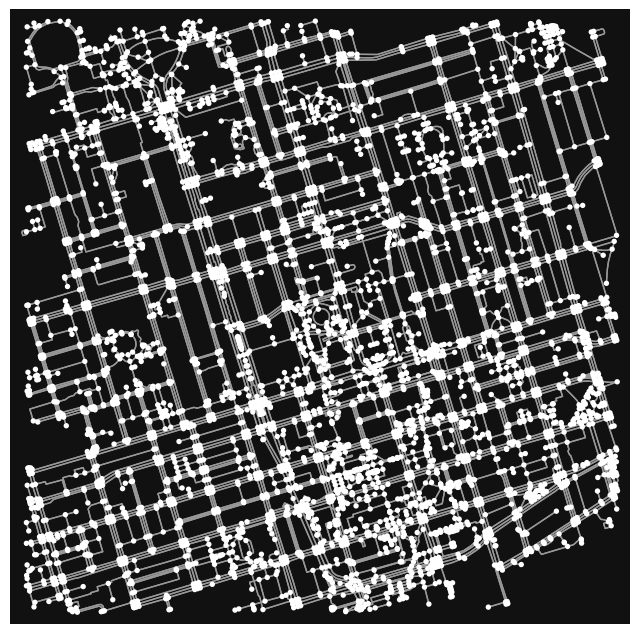

In [7]:
import osmnx as ox
import matplotlib.pyplot as plt

place_name = "Old Toronto, Toronto"

# fetch OSM street network (drive, walk, private, etc.) from the location
graph = ox.graph_from_address(place_name, network_type='walk')
fig, ax = ox.plot_graph(graph)